# Solving SIR model with PINN

In [611]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from SIRData import SIRData, CyclicSIRData
from utils import SINDy_sklearn, sample_collocation_points

## Generate Data from System

In [612]:
beta = 0.3
gamma = 1/21
theta = 0

X0 = torch.tensor([0.99, 0.01, 0.00])

In [613]:
time_int = [0, 60]
Nd = time_int[1]//7

time_points = np.linspace(time_int[0], time_int[1], Nd+1, endpoint=True)[1:]

# data = SIRData(X0, beta1, beta2, gamma1, gamma2, time_int, N=1000, time_points=time_points)
data = CyclicSIRData(X0, beta, gamma, theta, time_int, N=1000, time_points=time_points, noise_level=0.0)
td = data.td / time_int[1]
Xd = data.Xd

In [614]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0.reshape(-1, 3)

In [615]:
# Collocation points
N_coll = 1000
tc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid') / time_int[1]

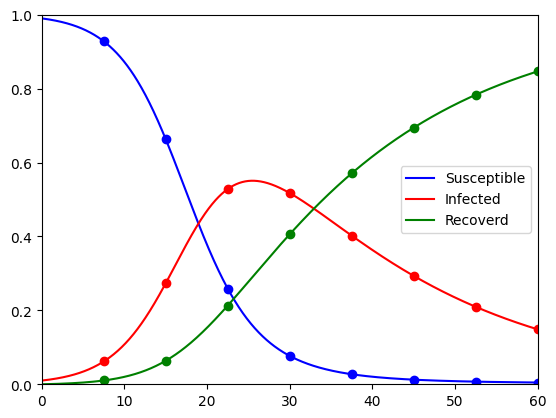

In [616]:
plt.plot(data.t_full, data.X_full[:,0], label='Susceptible', color='blue')
plt.plot(data.t_full, data.X_full[:,1], label='Infected', color='red')
plt.plot(data.t_full, data.X_full[:,2], label='Recoverd', color='green')
plt.scatter(td*time_int[1], data.Xd[:,0], color='blue')
plt.scatter(td*time_int[1], data.Xd[:,1], color='red')
plt.scatter(td*time_int[1], data.Xd[:,2], color='green')
plt.xlim(data.t_full[0], data.t_full[-1])
plt.ylim(0,1)
plt.legend()
plt.show()

### Known system $N_K$

In [617]:
class SIR(torch.nn.Module):
    
    def __init__(self, params):
        super(SIR, self).__init__()
        
        # Set the parameters
        for key, value in params.items():
            setattr(self, key, value) 

    def forward(self, z, U):

        lhs = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        S = U[:, 0]
        I = U[:, 1]
        R = U[:, 2]

        rhs = torch.stack([
            -self.beta*S*I,
            self.beta*S*I - self.gamma*I,
            self.gamma*I
        ], dim=-1)

        # norm = torch.maximum(torch.abs(lhs), torch.abs(rhs)) + 1e-6

        return lhs, rhs


params = dict(
    beta=beta,
    gamma=gamma,
    theta=theta
)

N = SIR(params)

### Problem specific UPINN functions

In [618]:
class SIR_UPINN(UPINN):

    def score(self):
        u_pred = self.u(data.t_full)
        return torch.sqrt(torch.mean((u_pred - data.X_full)**2) / torch.mean(data.X_full**2))
    
    # def get_loss(self):
    #     bc_loss = self.bc_loss()
    #     data_loss = self.data_loss()
    #     pde_loss = self.pde_loss()

    #     u_pred = self.u(self.collocation_points)
    #     population_loss = torch.mean((1 - torch.sum(u_pred, dim=1))**2)
        
    #     loss = self.lambdas[0]*bc_loss + self.lambdas[1]*data_loss + self.lambdas[2]*pde_loss + 1e-3*population_loss

    #     return loss, bc_loss, data_loss, pde_loss
    
    def pde_loss(self):
        u_pred = self.u(self.collocation_points)
        lhs, rhs = self.N(self.collocation_points, u_pred)
        
        norm = torch.maximum(torch.abs(lhs), torch.abs(rhs)) + 1e-8
        res_norm = (lhs - rhs) / norm

        # return torch.mean(res_norm**2) + torch.mean((1-torch.sum(u_pred, dim=1))**2)
        return torch.mean(res_norm**2)


    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            # Get network predictions
            u_pred = self.u(data.t_full)

            plt.plot(data.t_full, data.X_full[:,0], label='S', linestyle='--', color='b')
            plt.plot(data.t_full, data.X_full[:,1], label='I', linestyle='--', color='y')
            plt.plot(data.t_full, data.X_full[:,2], label='R', linestyle='--', color='r')
            plt.plot(data.t_full, u_pred[:,0].detach().numpy(), label='S pred', color='b')
            plt.plot(data.t_full, u_pred[:,1].detach().numpy(), label='I pred', color='y')
            plt.plot(data.t_full, u_pred[:,2].detach().numpy(), label='R pred', color='r')
            plt.legend()
            plt.show()



### Setup UPINN

In [619]:
class SIRNet(FNN):
    def forward(self, z):
        # z = (z - td.min()) / (td.max() - td.min())
        z = super().forward(z)
        z = torch.nn.functional.softplus(z)
        return z / torch.sum(z, dim=1, keepdim=True)

In [620]:
# Define model architectures
hidden = [16] * 3
# u = FNN(
#     dims=[1, *hidden, 3],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Softmax(),
# )
u = SIRNet(
    dims=[1, *hidden, 3],
    hidden_act=torch.nn.Tanh(),
)

In [621]:
# model = SIR_UPINN(u, N, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=tc)
model = SIR_UPINN(u, N, boundary_points=(tbc, Xbc), collocation_points=tc)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


### Train

In [622]:
model.to('cpu')
adamw = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adamw, patience=1000, factor=0.5, min_lr=1e-6, verbose=True)
# model.scheduler = scheduler
model.optimizer = adamw

In [623]:
# model.load('sir_pinn_softplus', 'models')

In [624]:
name = 'sir_pinn_norm'
# model.save(name, 'models')
# np.save(f'logs/{name}_losses.npy', model.log)

In [625]:
model.score().item()

0.6131771802902222

In [626]:
# len(model.log['loss'])

In [627]:
# model.train_loop(6500)

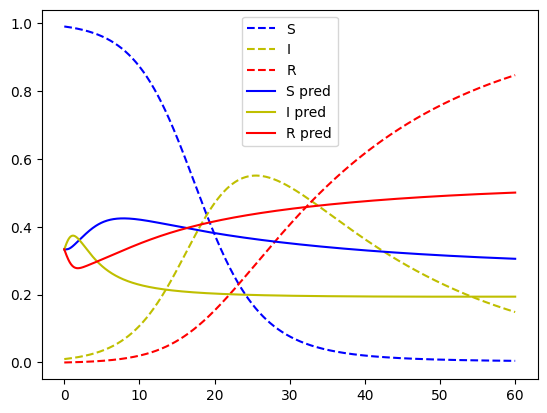

In [628]:
model.plot()

In [629]:
for i in range(0, time_int[1]):
    model.collocation_points = sample_collocation_points(1000, 1, lb=[time_int[0]], ub=[i+1], method='grid').requires_grad_(True)
    model.train_loop(100)
    loss, _, _, _ = model.get_loss()
    while loss.item() > 1e-7:
        model.train_loop(500)
        loss, _, _, _ = model.get_loss()
    if i % 10 == 0:
        model.plot()

[Info]: Training 100 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 100/100 [00:01<00:00, 87.94 epoch/s, bc_loss=8.62e-02, data_loss=0.00e+00, pde_loss=6.48e-01, loss=7.34e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 88.32 epoch/s, bc_loss=2.48e-04, data_loss=0.00e+00, pde_loss=5.54e-01, loss=5.54e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 86.67 epoch/s, bc_loss=4.65e-05, data_loss=0.00e+00, pde_loss=5.52e-01, loss=5.52e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 84.59 epoch/s, bc_loss=3.91e-05, data_loss=0.00e+00, pde_loss=5.51e-01, loss=5.51e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.31 epoch/s, bc_loss=4.41e-05, data_loss=0.00e+00, pde_loss=5.51e-01, loss=5.51e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.21 epoch/s, bc_loss=4.88e-05, data_loss=0.00e+00, pde_loss=5.51e-01, loss=5.51e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 81.88 epoch/s, bc_loss=5.24e-05, data_loss=0.00e+00, pde_loss=5.51e-01, loss=5.51e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 80.23 epoch/s, bc_loss=5.51e-05, data_loss=0.00e+00, pde_loss=5.50e-01, loss=5.50e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 79.55 epoch/s, bc_loss=5.73e-05, data_loss=0.00e+00, pde_loss=5.50e-01, loss=5.50e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 76.21 epoch/s, bc_loss=5.91e-05, data_loss=0.00e+00, pde_loss=5.50e-01, loss=5.50e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 79.19 epoch/s, bc_loss=6.06e-05, data_loss=0.00e+00, pde_loss=5.50e-01, loss=5.50e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 78.49 epoch/s, bc_loss=6.19e-05, data_loss=0.00e+00, pde_loss=5.50e-01, loss=5.50e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 76.11 epoch/s, bc_loss=6.31e-05, data_loss=0.00e+00, pde_loss=5.50e-01, loss=5.50e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 80.08 epoch/s, bc_loss=6.41e-05, data_loss=0.00e+00, pde_loss=5.49e-01, loss=5.49e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 80.10 epoch/s, bc_loss=6.50e-05, data_loss=0.00e+00, pde_loss=5.48e-01, loss=5.48e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 79.75 epoch/s, bc_loss=6.58e-05, data_loss=0.00e+00, pde_loss=5.45e-01, loss=5.45e-01]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 77.87 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=7.35e-03, loss=7.41e-03]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 71.94 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.91e-04, loss=3.58e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 71.93 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.52e-04, loss=2.19e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 71.25 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=7.93e-05, loss=1.46e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 72.64 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=5.46e-05, loss=1.21e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 68.84 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=3.86e-05, loss=1.05e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 69.97 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.67e-05, loss=9.32e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 69.01 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.82e-05, loss=8.47e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 68.34 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.22e-05, loss=7.87e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 64.98 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=8.05e-06, loss=7.45e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 65.99 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=5.22e-06, loss=7.17e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 65.10 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=3.33e-06, loss=6.98e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 64.09 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.07e-06, loss=6.86e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 66.03 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.37e-06, loss=6.79e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 64.22 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=9.70e-07, loss=6.75e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 61.87 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=7.39e-07, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 65.03 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=7.73e-07, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 48.95 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.09e-06, loss=6.76e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 55.94 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.71e-06, loss=6.82e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 58.76 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=8.88e-07, loss=6.74e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 54.98 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=7.67e-06, loss=7.42e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 57.77 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.73e-06, loss=6.82e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 55.85 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.98e-06, loss=6.85e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 57.85 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.46e-06, loss=6.89e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 56.60 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.28e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 57.21 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.56e-05, loss=8.21e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 54.57 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.12e-06, loss=6.86e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 53.85 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.55e-06, loss=6.90e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 55.65 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=3.75e-06, loss=7.02e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 55.08 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=8.48e-07, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 55.33 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=7.86e-08, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 56.19 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=4.14e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 54.93 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=4.32e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 52.34 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.79e-06, loss=6.93e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 51.51 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=3.58e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 53.03 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=4.97e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 52.01 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=5.48e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 50.25 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=3.36e-06, loss=6.98e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 53.62 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=5.13e-06, loss=7.16e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 51.16 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=7.39e-07, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 47.44 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=5.91e-07, loss=6.71e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 49.37 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.55e-06, loss=6.90e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 51.81 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=9.72e-07, loss=6.74e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 49.89 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=9.05e-07, loss=6.74e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 48.80 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=4.15e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 48.40 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=5.50e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 49.19 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=6.62e-07, loss=6.71e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 50.82 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=4.55e-06, loss=7.10e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 46.50 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=9.99e-08, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 46.06 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.76e-06, loss=6.92e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 48.70 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.32e-06, loss=6.88e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 48.27 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=4.62e-06, loss=7.11e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:13<00:00, 37.00 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.02e-05, loss=8.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:16<00:00, 30.46 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=3.95e-06, loss=7.04e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:13<00:00, 36.52 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=4.88e-06, loss=7.14e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:11<00:00, 43.05 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=7.50e-07, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:11<00:00, 42.27 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.35e-05, loss=8.99e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 33.82 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=5.07e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:17<00:00, 28.58 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.11e-06, loss=6.76e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:17<00:00, 28.69 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=9.28e-07, loss=6.74e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:15<00:00, 33.31 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.84e-06, loss=6.83e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 45.78 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.34e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:11<00:00, 44.70 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.25e-06, loss=6.87e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:11<00:00, 45.31 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=4.62e-06, loss=7.11e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:11<00:00, 44.43 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=3.05e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:11<00:00, 44.41 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.22e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:11<00:00, 43.29 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.11e-06, loss=6.86e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 45.65 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.33e-05, loss=7.97e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:11<00:00, 43.76 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=4.78e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:11<00:00, 43.84 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=1.41e-06, loss=6.79e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:12<00:00, 40.55 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=4.69e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:12<00:00, 39.56 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.21e-06, loss=6.87e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:11<00:00, 41.93 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=4.31e-06, loss=7.08e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:17<00:00, 28.40 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=7.51e-07, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:19<00:00, 26.17 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=9.32e-07, loss=6.74e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:19<00:00, 26.03 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=2.96e-06, loss=6.94e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:19<00:00, 25.58 epoch/s, bc_loss=6.65e-05, data_loss=0.00e+00, pde_loss=6.17e-06, loss=7.26e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:18<00:00, 27.09 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.53e-06, loss=6.80e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:19<00:00, 25.77 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=4.63e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 22.92 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.55e-06, loss=6.80e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.33 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.45e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.61 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=8.41e-07, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.08 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.05e-06, loss=6.75e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:13<00:00, 37.10 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.26e-06, loss=6.97e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:12<00:00, 39.70 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=4.00e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.75 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.90e-06, loss=6.83e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 21.01 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=6.95e-06, loss=7.34e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.61 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.26e-06, loss=6.77e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.34 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=8.33e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.22 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.58e-06, loss=6.90e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:18<00:00, 26.45 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=4.91e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.63 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.74e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.52 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.35e-06, loss=6.78e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.35 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.49e-06, loss=6.79e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:26<00:00, 18.97 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.98e-06, loss=6.84e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:19<00:00, 25.34 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=5.07e-06, loss=7.15e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:13<00:00, 37.70 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.53e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 35.66 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=5.87e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 33.55 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.22e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:13<00:00, 36.60 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.18e-05, loss=8.82e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:13<00:00, 36.40 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=5.71e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 35.18 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.14e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:13<00:00, 36.88 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.06e-06, loss=6.75e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.50 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.45e-06, loss=6.99e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:19<00:00, 25.35 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=5.65e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:13<00:00, 36.67 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.29e-05, loss=7.94e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 33.99 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=6.08e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:13<00:00, 36.43 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.92e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:16<00:00, 30.09 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.22e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.65 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.43e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:15<00:00, 32.71 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=7.55e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:12<00:00, 38.52 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.14e-06, loss=6.76e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:13<00:00, 37.19 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.12e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 35.34 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.45e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 35.23 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=5.58e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 34.71 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.26e-06, loss=6.77e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 34.93 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.19e-06, loss=6.96e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 34.80 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=7.70e-07, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 34.66 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=9.46e-07, loss=6.74e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 34.16 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=4.85e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 34.13 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=4.43e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 34.20 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=8.82e-07, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:15<00:00, 32.70 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.92e-06, loss=6.83e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 33.54 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.92e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 33.64 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=8.36e-07, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:14<00:00, 33.35 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.03e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:15<00:00, 33.29 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=6.32e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:15<00:00, 33.26 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.86e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:15<00:00, 32.90 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=9.19e-07, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:15<00:00, 32.75 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.71e-06, loss=6.81e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:15<00:00, 33.06 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.03e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:16<00:00, 30.63 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.66e-06, loss=6.81e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:15<00:00, 32.35 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.47e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:16<00:00, 31.01 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.35e-06, loss=6.77e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.32 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.32e-06, loss=6.77e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 16.68 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.51e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:31<00:00, 16.08 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=7.63e-07, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.54 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.79e-06, loss=7.02e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:30<00:00, 16.14 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=7.29e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:31<00:00, 15.75 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.31e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:32<00:00, 15.51 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.91e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:30<00:00, 16.32 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=6.22e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:34<00:00, 14.40 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=7.69e-07, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:33<00:00, 14.74 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=9.16e-07, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:28<00:00, 17.34 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=7.04e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:16<00:00, 30.44 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.73e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.28 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.06e-05, loss=7.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.64 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.43e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 21.83 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=6.22e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.81 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.91e-06, loss=6.83e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:19<00:00, 25.90 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.42e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:28<00:00, 17.82 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=5.32e-06, loss=7.17e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 17.01 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.96e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:30<00:00, 16.53 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=8.25e-06, loss=7.46e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.63 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.39e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:31<00:00, 15.85 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.52e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:32<00:00, 15.50 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.86e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:32<00:00, 15.40 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.15e-06, loss=6.75e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:33<00:00, 15.10 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.90e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:34<00:00, 14.39 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.33e-06, loss=6.97e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:35<00:00, 14.27 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=5.89e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:35<00:00, 14.22 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=8.21e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:36<00:00, 13.83 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=4.06e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:36<00:00, 13.68 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=4.46e-06, loss=7.08e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:36<00:00, 13.57 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.91e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:37<00:00, 13.48 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.74e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:37<00:00, 13.37 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=7.49e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:37<00:00, 13.25 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.83e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:38<00:00, 13.14 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=5.16e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:38<00:00, 13.06 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.24e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:38<00:00, 13.02 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=9.13e-08, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:38<00:00, 12.88 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.55e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:38<00:00, 12.83 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.32e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:39<00:00, 12.68 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=7.57e-07, loss=6.71e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:40<00:00, 12.50 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=4.64e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:40<00:00, 12.24 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.27e-05, loss=7.90e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:41<00:00, 12.05 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.58e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:41<00:00, 12.01 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=3.16e-06, loss=6.95e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:42<00:00, 11.82 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.31e-06, loss=6.87e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:42<00:00, 11.73 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.15e-05, loss=7.79e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:42<00:00, 11.65 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.06e-06, loss=6.84e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:42<00:00, 11.70 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.94e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:43<00:00, 11.59 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=2.61e-06, loss=6.90e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:43<00:00, 11.52 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=5.26e-06, loss=7.16e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:42<00:00, 11.64 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=1.63e-06, loss=6.80e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:43<00:00, 11.50 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=6.16e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:43<00:00, 11.51 epoch/s, bc_loss=6.64e-05, data_loss=0.00e+00, pde_loss=5.00e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:43<00:00, 11.43 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=4.10e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:43<00:00, 11.39 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.14e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:43<00:00, 11.39 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.22e-06, loss=6.76e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:44<00:00, 11.30 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=8.24e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:44<00:00, 11.28 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=4.07e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:44<00:00, 11.23 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.19e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:44<00:00, 11.28 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.96e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:44<00:00, 11.19 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.63e-06, loss=6.80e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:45<00:00, 11.10 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.42e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:45<00:00, 11.01 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=9.13e-07, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:45<00:00, 10.91 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=6.10e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:45<00:00, 10.92 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.43e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:45<00:00, 10.92 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=7.05e-06, loss=7.34e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:46<00:00, 10.83 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.32e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:37<00:00, 13.23 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.43e-06, loss=6.78e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:18<00:00, 27.29 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=8.42e-06, loss=7.48e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:19<00:00, 25.73 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=7.58e-07, loss=6.71e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:20<00:00, 24.79 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.58e-06, loss=6.79e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:20<00:00, 24.67 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.29e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:20<00:00, 24.59 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.72e-06, loss=7.00e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:20<00:00, 24.78 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.04e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:18<00:00, 26.80 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.36e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:20<00:00, 24.88 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.24e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:20<00:00, 24.40 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.53e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:20<00:00, 24.16 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.26e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:20<00:00, 24.12 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.90e-06, loss=7.02e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.67 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=9.81e-07, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:20<00:00, 23.98 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.47e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:20<00:00, 23.88 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.96e-06, loss=7.03e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.27 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=7.90e-06, loss=7.42e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:20<00:00, 23.86 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=5.90e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.56 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.07e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.64 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=6.94e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.53 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.74e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.37 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.21e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.35 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.47e-06, loss=6.78e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.29 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.55e-06, loss=6.89e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 22.88 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=4.73e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 22.90 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=5.33e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.05 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.45e-06, loss=6.88e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 23.07 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=7.11e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 22.87 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=5.45e-08, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 22.76 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.24e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 22.97 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.63e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 22.73 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.67e-06, loss=6.80e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.70 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=6.24e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.00 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.31e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 22.99 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=6.23e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 22.79 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.08e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 22.96 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=4.51e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.68 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.08e-06, loss=6.94e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:21<00:00, 22.82 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.25e-06, loss=6.75e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.64 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=9.31e-07, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.71 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=4.81e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 21.82 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.62e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.42 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.67e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.35 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=6.43e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.33 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=8.81e-07, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.11 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=7.80e-06, loss=7.41e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.07 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.85e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 22.16 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.63e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 21.92 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.42e-06, loss=6.97e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 21.43 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.90e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 21.91 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=5.49e-06, loss=7.18e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 21.80 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.76e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 21.77 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=9.20e-06, loss=7.55e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:22<00:00, 21.78 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.87e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 21.70 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=3.11e-06, loss=6.94e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 21.66 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=8.80e-07, loss=6.71e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 21.51 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=4.89e-06, loss=7.12e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 20.98 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=5.71e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 21.41 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=2.00e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 21.30 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.11e-06, loss=6.74e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 21.26 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=4.28e-06, loss=7.05e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 21.22 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=5.97e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 21.25 epoch/s, bc_loss=6.63e-05, data_loss=0.00e+00, pde_loss=1.54e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 21.20 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.62e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 20.97 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=4.44e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.58 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.59e-06, loss=6.78e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 20.89 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=2.14e-06, loss=6.84e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 20.90 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=2.75e-06, loss=6.90e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 20.84 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=3.28e-06, loss=6.95e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:23<00:00, 20.86 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=7.05e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.70 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=2.53e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.74 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=8.16e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.07 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=7.85e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.48 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.36e-06, loss=6.76e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.39 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=4.88e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.29 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=7.39e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.35 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.57e-08, loss=6.62e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.26 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=3.41e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.22 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=2.14e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.87 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.39e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.03 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=7.48e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.22 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=6.24e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.05 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=5.43e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:24<00:00, 20.05 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=8.05e-07, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.94 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=2.04e-06, loss=6.82e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.96 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=5.61e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.80 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=9.02e-08, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.40 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.13e-06, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.91 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.26e-08, loss=6.62e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.79 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.02e-06, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.76 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=8.81e-07, loss=6.71e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.55 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=5.04e-06, loss=7.12e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.65 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=5.76e-06, loss=7.20e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.55 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=2.27e-06, loss=6.85e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:26<00:00, 19.00 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=4.30e-06, loss=7.05e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.48 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.11e-06, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.38 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=7.17e-06, loss=7.33e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.34 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.37e-07, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:26<00:00, 19.20 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=6.10e-08, loss=6.62e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:26<00:00, 19.17 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=2.79e-06, loss=6.90e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:26<00:00, 19.15 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.92e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:26<00:00, 18.74 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=5.87e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:26<00:00, 18.99 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=7.40e-06, loss=7.36e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:27<00:00, 18.40 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.17e-06, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:26<00:00, 18.65 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.69e-08, loss=6.62e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:42<00:00, 11.73 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=5.45e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:27<00:00, 18.22 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=2.59e-08, loss=6.62e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:41<00:00, 12.04 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.78e-06, loss=6.79e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:32<00:00, 15.34 epoch/s, bc_loss=6.62e-05, data_loss=0.00e+00, pde_loss=1.43e-06, loss=6.76e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:25<00:00, 19.40 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.62e-06, loss=6.78e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 16.95 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.95e-07, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 17.10 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.15e-06, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:49<00:00, 10.17 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=3.80e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:30<00:00, 16.31 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=4.06e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:28<00:00, 17.55 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.09e-06, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:43<00:00, 11.46 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.58e-07, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:52<00:00,  9.52 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=2.32e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:55<00:00,  9.01 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.70e-06, loss=6.78e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:32<00:00, 15.58 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=4.70e-06, loss=7.08e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:27<00:00, 18.08 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=5.13e-08, loss=6.62e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:28<00:00, 17.85 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.19e-06, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:27<00:00, 18.15 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.43e-05, loss=8.04e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 17.12 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=2.04e-05, loss=8.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:32<00:00, 15.16 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=2.18e-07, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:48<00:00, 10.35 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=7.65e-07, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:53<00:00,  9.42 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=2.53e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:54<00:00,  9.14 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=8.69e-09, loss=6.61e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:51<00:00,  9.74 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.32e-05, loss=7.93e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:28<00:00, 17.25 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=2.03e-06, loss=6.81e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:30<00:00, 16.64 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=5.81e-06, loss=7.19e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:28<00:00, 17.73 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=6.68e-08, loss=6.61e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 17.20 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=5.65e-08, loss=6.61e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:28<00:00, 17.64 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=5.29e-08, loss=6.61e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:33<00:00, 14.84 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=3.48e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:30<00:00, 16.51 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=5.62e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 16.89 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.22e-06, loss=6.73e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 17.05 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=4.07e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:28<00:00, 17.45 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.20e-07, loss=6.62e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:32<00:00, 15.36 epoch/s, bc_loss=6.61e-05, data_loss=0.00e+00, pde_loss=1.63e-06, loss=6.77e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:31<00:00, 15.78 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=4.60e-06, loss=7.06e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 17.10 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=6.02e-06, loss=7.21e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:39<00:00, 12.77 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=5.50e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:34<00:00, 14.53 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=4.69e-07, loss=6.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 17.15 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=4.00e-06, loss=7.00e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 17.23 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=4.60e-08, loss=6.61e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:36<00:00, 13.71 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=1.10e-08, loss=6.60e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:42<00:00, 11.77 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=7.08e-08, loss=6.61e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:59<00:00,  8.47 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=1.01e-06, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:59<00:00,  8.34 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=2.16e-07, loss=6.62e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [01:02<00:00,  7.94 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=8.72e-09, loss=6.60e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [01:05<00:00,  7.65 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=1.15e-06, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:48<00:00, 10.39 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=3.42e-08, loss=6.60e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [01:01<00:00,  8.13 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=1.16e-06, loss=6.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [01:02<00:00,  8.04 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=3.96e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [01:03<00:00,  7.85 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=5.97e-07, loss=6.66e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:39<00:00, 12.66 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=2.78e-08, loss=6.60e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:51<00:00,  9.78 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=3.59e-07, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:58<00:00,  8.48 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=1.45e-08, loss=6.60e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [01:02<00:00,  8.00 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=7.12e-08, loss=6.60e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:40<00:00, 12.41 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=3.35e-07, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:45<00:00, 11.01 epoch/s, bc_loss=6.60e-05, data_loss=0.00e+00, pde_loss=2.50e-07, loss=6.62e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 16.79 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=2.89e-07, loss=6.62e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:31<00:00, 16.02 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=3.22e-06, loss=6.92e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:39<00:00, 12.55 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=7.36e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:38<00:00, 13.04 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=1.01e-06, loss=6.69e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:31<00:00, 15.78 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=4.67e-07, loss=6.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:30<00:00, 16.43 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=1.99e-07, loss=6.61e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:31<00:00, 15.83 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=1.07e-06, loss=6.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:34<00:00, 14.42 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=1.67e-07, loss=6.61e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:41<00:00, 12.06 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=8.09e-07, loss=6.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:32<00:00, 15.57 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=3.75e-07, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 16.85 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=1.04e-08, loss=6.59e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:29<00:00, 17.10 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=8.93e-07, loss=6.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:36<00:00, 13.84 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=1.36e-07, loss=6.60e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:37<00:00, 13.47 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=3.07e-06, loss=6.89e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:33<00:00, 15.08 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=4.74e-07, loss=6.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]:  81%|████████  | 403/500 [00:26<00:06, 15.06 epoch/s, bc_loss=6.59e-05, data_loss=0.00e+00, pde_loss=3.91e-07, loss=6.62e-05]


KeyboardInterrupt: 

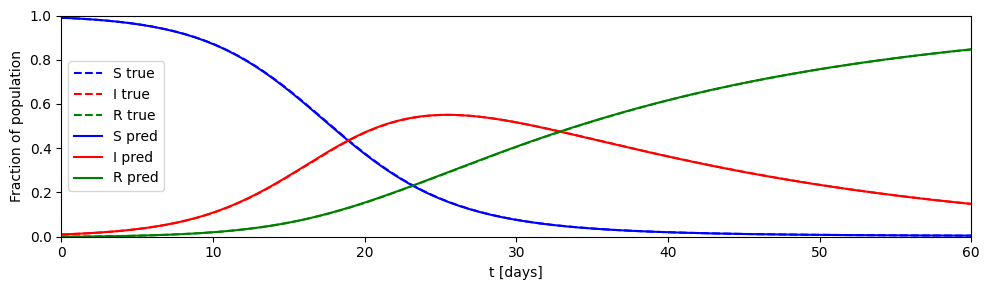

In [610]:
plt.figure( figsize=(10, 3))
u_pred = model.u(data.t_full)
plt.plot(data.t_full, data.X_full[:,0], label='S true', linestyle='--', color='b')
plt.plot(data.t_full, data.X_full[:,1], label='I true', linestyle='--', color='r')
plt.plot(data.t_full, data.X_full[:,2], label='R true', linestyle='--', color='g')
plt.plot(data.t_full, u_pred[:,0].detach().numpy(), label='S pred', color='b')
plt.plot(data.t_full, u_pred[:,1].detach().numpy(), label='I pred', color='r')
plt.plot(data.t_full, u_pred[:,2].detach().numpy(), label='R pred', color='g')
plt.legend()
plt.xlabel('t [days]')
plt.ylabel('Fraction of population')
plt.xlim(data.t_full[0], data.t_full[-1])
plt.ylim(0,1)
plt.savefig('gfx/sir_pinn.pdf', bbox_inches='tight', format='pdf')
plt.tight_layout()
plt.show()